# Figures and Results for Presentation

In [1]:
import csv
import numpy as np
import pandas as pd
import utils 
from copy import deepcopy
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

from models import Level_K_Model, Temporal_Level_Model
from hist_models import History_Mapping_Model,  Bounded_Memory_Map

import matplotlib.pyplot as plt

In [2]:
def ll_uniform(dataset):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = np.ones(2) / 2
            
            L = traj.shape[1] #length of trajectory
            for l in range(L):
                idx = np.where(traj[:, l])
                ll += np.log(s[idx[0][0]])
        
    return -ll

In [3]:
def ll_fixed_strat(dataset, S):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = S[player]
            
            L = traj.shape[1] #length of trajectory
            for l in range(L):
                idx = np.where(traj[:, l])
                ll += np.log(s[idx[0][0]])

    return -ll


In [4]:
data = utils.load_data('data_new.csv')
test_data = utils.load_data('general_data.csv')

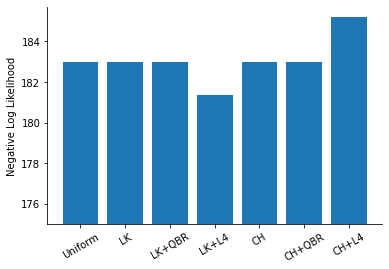

In [5]:
# Predictions of Models for NF games

fixed_prediction = {
    'LK'  :  [np.array([0.5, 0.5]),   np.array([0.5, 0.5])],
    'LK+QBR' : [np.array([0.5, 0.5]),  np.array([0.5 ,0.5])],
    'LK+L4' :  [np.array([0.4538946, 0.5461054]),   np.array([0.4538946, 0.5461054])],
    'CH' : [np.array([0.5, 0.5]),  np.array([0.5, 0.5])],
    'CH+QBR': [np.array([0.5, 0.5]),  np.array([0.5, 0.5])],
    'CH+L4': [np.array([0.52931229, 0.47068771]) , np.array([0.52931229 ,0.47068771])]
}

labels = ['Uniform']
nlls = [ll_uniform(data)]

for k, v in fixed_prediction.items():
    nll = ll_fixed_strat(data, v)

    labels.append(k)
    nlls.append(nll)


start = 175
x_pos = np.arange(0, len(labels))
plt.bar(x_pos, np.array(nlls)-start, bottom=start)
plt.ylabel('Negative Log Likelihood')
plt.xticks(x_pos, labels , rotation=30  )


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('presentation_figures/default_models.png', dpi=300, bbox_inches='tight')


In [8]:
models = [Level_K_Model(1), Level_K_Model(2),  History_Mapping_Model(1), Bounded_Memory_Map(1)]

In [9]:
train_ll = np.zeros(len(models)+1)
test_ll = np.zeros(len(models)+1)

train_ll[0] = ll_uniform(data)
test_ll[0] = ll_uniform(test_data)

for i, m in enumerate(models):
    results = m.fit(data)
    params = results.x
    test_ll[i+1] =  m.log_likelihood(params, test_data)
    train_ll[i+1] = results.fun


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (5,).

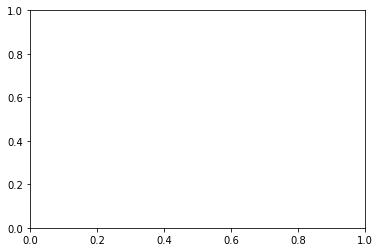

In [10]:
labels = ['Unif.',  'LK(1)', 'LK(2)', 'BMM(1)' ]

start = 150

x_pos = np.arange(0, len(labels))
plt.bar(x_pos, train_ll-start, bottom=start)
plt.ylabel('Negative Log Likelihood')
plt.xticks(x_pos, labels )


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('presentation_figures/new_models.png', dpi=300, bbox_inches='tight')


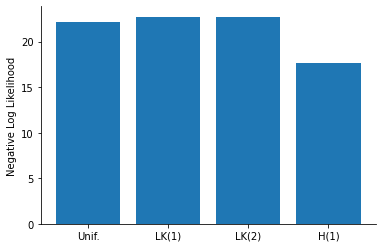

In [83]:
start = 0
x_pos = np.arange(0, len(labels))
plt.bar(x_pos, test_ll-start, bottom=start)
plt.ylabel('Negative Log Likelihood')
plt.xticks(x_pos, labels)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('presentation_figures/new_models_test.png', dpi=300, bbox_inches='tight')

In [ ]:
def k_folds(data, m):
    results = []
    test_losses = []
    for i in range(len(data)):
        train_data = deepcopy(data)
        test_data = deepcopy(train_data[i])
        del train_data[i]

        res = m.fit(train_data)
        params = res.x
        test_loss = m.log_likelihood(params, [test_data])
        results.append(res)
        test_losses.append(test_loss)

    return results, test_losses

In [57]:
test_losses  = np.zeros((len(models), len(data)))
for m_i, m in enumerate(models):
    for i in range(len(data)):
            train_data = deepcopy(data)
            test_data = deepcopy(train_data[i])
            del train_data[i]
            res = m.fit(train_data)
            params = res.x
            test_losses[m_i, i] = m.log_likelihood(params, [test_data])

In [59]:
test_losses_unif = np.zeros(len(data))

for i in range(len(data)):
        train_data = deepcopy(data)
        test_data = deepcopy(train_data[i])
        test_losses_unif [i] = ll_uniform([test_data])

In [60]:
test_losses_unif

array([ 6.93147181,  4.15888308, 16.63553233,  6.93147181,  9.70406053,
        5.54517744, 19.40812106,  2.77258872,  6.93147181,  4.15888308,
        5.54517744,  2.77258872, 12.47664925, 15.24923797,  5.54517744,
        8.31776617,  5.54517744,  2.77258872,  9.70406053,  6.93147181,
        4.15888308,  4.15888308,  5.54517744, 11.09035489])

In [84]:
np.mean(test_losses-test_losses_unif, axis=1)

array([ 0.18166277,  0.30053515, -0.7928463 ])